# MuhRec in python demonstration
This is a first hello world demonstration of the MuhRec python bindings.

You will:
- Load the modules
- Test a dummy reconstruction of a cylinder
- Load projection data
- Normalize the projections
- Find center of rotation
- Reconstruct some slices


In [1]:
import sys
sys.path.append('../../deployed/') # or where ever you placed the package



In [2]:
import numpy as np
import matplotlib.pyplot as plt

import nitools.utils.readers as io
import nitools.utils.imageutils as amg

import nitools.imgalg.muhrectomo as mt
import nitools.imgalg.imgalg as ia


## Create a reconstructor object

In [4]:
recon = mt.Reconstructor(mt.bpMultiProj)

print("Created reconstructor :",recon.name())

Created reconstructor : Multi projection BP


## Reconstruction workflow

### Numerical dummy
This dummy is only to test the connection and that the reconstructor starts at all. Only nonsense data.

In [5]:
Nproj = 10
proj = np.ones([Nproj,256,256])

In [6]:
args = {"angles" : np.linspace(0,180,num=Nproj), 
        "weights" : np.ones(Nproj)}

In [7]:
recon.configure({   "center" : 50, 
                    "resolution" : 0.135
                })

In [8]:
recon.process(proj,args)

vol = recon.volume()

256 256 10


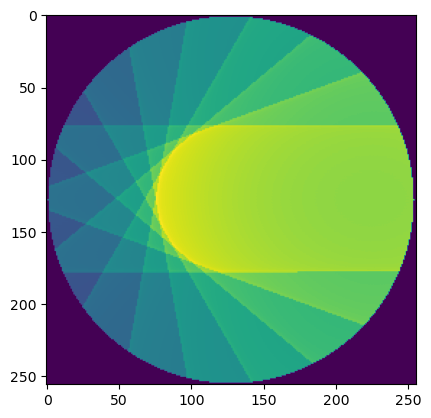

In [9]:
plt.imshow(vol[0])

### The wood data
The wood data is the data I use a lot for demos, tests, and tutorials. It a piece of petrified wood [DOI](http://dx.doi.org/10.17632/g5snr785xy.2). 

#### Load projection data

In [10]:
ob = io.read_images('/home/kaestner/data/wooddata/projections/ob_{0:04d}.tif',0,4,averageStack=True).mean(axis=0)
dc = io.read_images('/home/kaestner/data/wooddata/projections/dc_{0:04d}.tif',0,4,averageStack=True).mean(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
proj = io.read_images('/home/kaestner/data/wooddata/projections/wood_{0:04d}.tif',0,625) # This takes a while

  0%|          | 0/626 [00:00<?, ?it/s]

In [14]:
proj.dtype

dtype('float32')

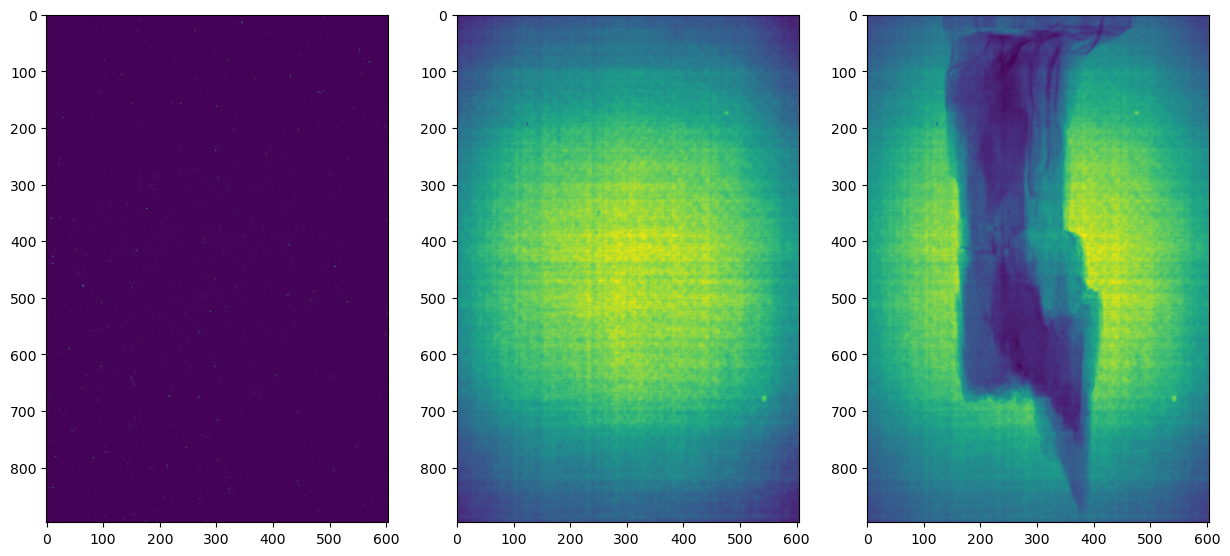

In [15]:
fig,ax = plt.subplots(1,3,figsize=[15,7])
ax[0].imshow(dc)
ax[1].imshow(ob)
ax[2].imshow(proj[0])


## Preprocessing
Here the projections needs to be prepared for reconstruction. Typical operations are 
- Cropping
- Normalization (possibly with scattering correction)
- Spot cleaning
- Ring cleaning

### Normalize - the kipl way

In [16]:
help(ia)

Help on module nitools.imgalg.imgalg in nitools.imgalg:

NAME
    nitools.imgalg.imgalg

CLASSES
    builtins.Exception(builtins.BaseException)
        ImagingException
    pybind11_builtins.pybind11_object(builtins.object)
        AverageImage
        MorphSpotClean
        NormalizeImage
        PolynomialCorrection
        ProjectionFilter
        StripeFilter
        TomoCenter
        eCenterEstimator
        eMorphCleanMethod
        eMorphDetectionMethod
        eProjectionFilterType
        eStripeFilterOperation
    
    class AverageImage(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      AverageImage
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(...)
     |      __init__(self: nitools.imgalg.imgalg.AverageImage) -> None
     |  
     |  process(...)
     |      process(self: nitools.imgalg.imgalg.AverageImage, img: numpy.ndarray[numpy.float32], method: Im

In [17]:
norm = ia.NormalizeImage(True) # True for use logarithm

In [18]:
norm.usingLog()

True

In [19]:
norm = ia.NormalizeImage(True) # True for use logarithm
norm.setReferences(ob,dc)
cproj = proj.copy()
norm.process(cproj)

## Normalize - the python way

In [20]:
nproj = amg.normalizeImage(img=proj, ob=ob, dc=dc, neglog=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:04<00:00, 133.32it/s]


In [21]:
nproj.dtype

dtype('float64')

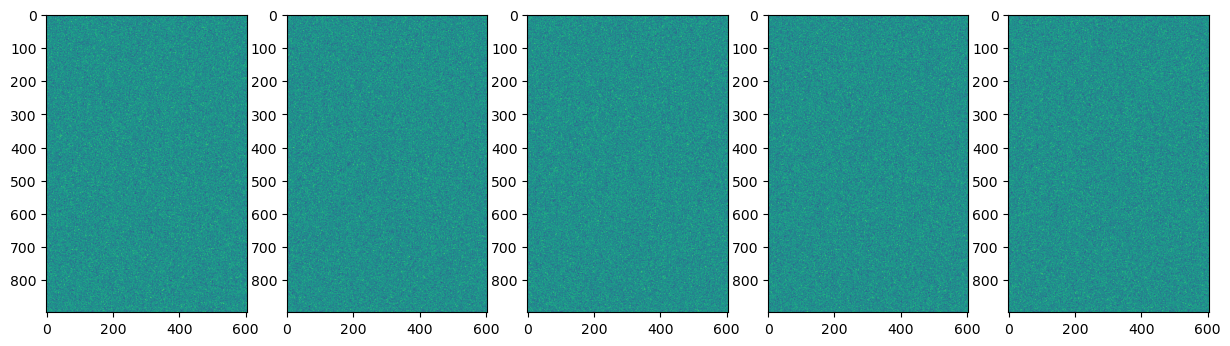

In [22]:
fig,axes=plt.subplots(1,5,figsize=(15,4))

for idx,ax in enumerate(axes) :
    ax.imshow(cproj[idx*20]-nproj[idx*20])

In [23]:
print(nproj.shape,cproj.shape)

(626, 897, 604) (626, 897, 604)


(626, 897, 604)

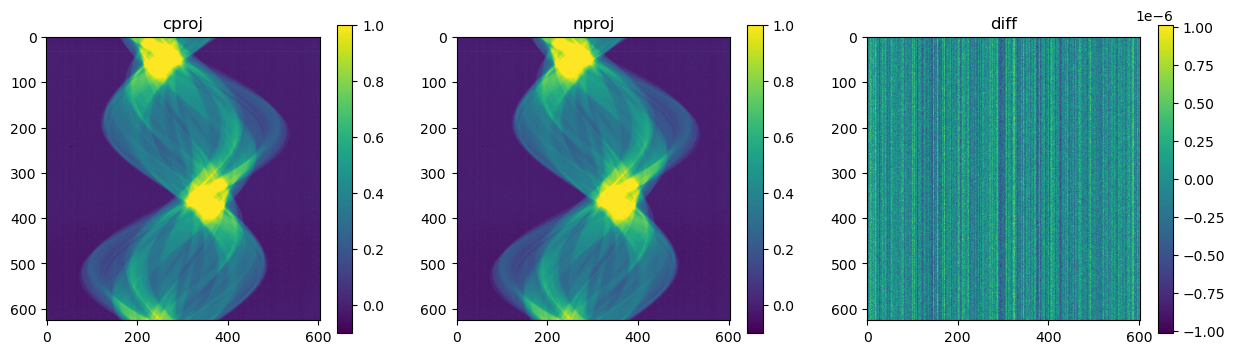

In [24]:
fig,axes=plt.subplots(1,3,figsize=(15,4))
a0=axes[0].imshow(cproj[:,400,:], vmin=-0.1,vmax=1); axes[0].set_title('cproj')
fig.colorbar(a0,ax=axes[0])
a1=axes[1].imshow(nproj[:,400,:], vmin=-0.1,vmax=1); axes[1].set_title('nproj')
fig.colorbar(a1,ax=axes[1])
a2=axes[2].imshow(cproj[:,400,:]-nproj[:,400,:]); axes[2].set_title('diff')
fig.colorbar(a2,ax=axes[2])

cproj.shape

#### Prepare and run the back-projection

In [25]:
ce = ia.TomoCenter()

center=ce.estimate(cproj[0,:,:],cproj[312,:,:],ia.centerLeastSquare,True)

In [26]:
Nproj = cproj.shape[0]
# Information per projection
args = {"angles"  : np.linspace(0,360,num=Nproj), 
        "weights" : np.ones(Nproj)/Nproj
       }

# Geometry information
recon.configure({   "center" : center[0],
#                     "tilt" : center[1],
#                     "pivot" : center[2],
                    "resolution" : 0.1
                })
print("have",Nproj,"projections")

have 626 projections


In [27]:
recon.process(cproj[:,500:510,:].astype('float64'),args) # Reconstruct a part of the slices (32 slices here)
del vol
vol = recon.volume() # Retrieve the reconstructed volume

604 10 626


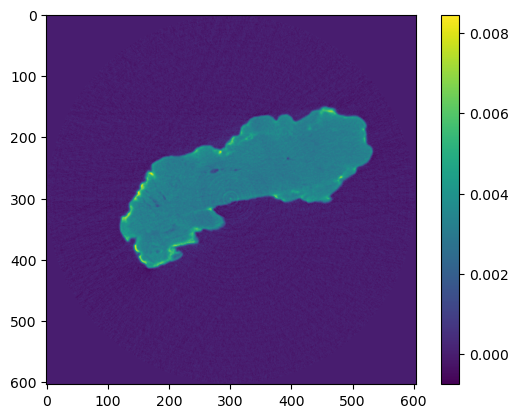

In [28]:
plt.imshow(vol[0])
plt.colorbar()
plt.savefig('recon.png',dpi=300)

## Next steps

This notebook demonstrated that the python bindings work. The next step is to do some more serious reconstruction work.
- Sample tilt correction
- Activate multithreading
- Apply cleaning algorithms
    - Spot cleaning
    - Ring cleaning
- Basic volume rendering